In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.utils.convtools import compute_output_shape, conviter
import scipy as sp

In [2]:
def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def moving_average(data: np.ndarray, kernel_size: int = 20) -> np.ndarray:
    """
    Compute the moving average of a given data array.

    Parameters
    ----------
    data : np.ndarray
        The data array.
    kernel_size : int
        The size of the kernel.

    Returns
    -------
    np.ndarray
        The moving average of the data array.
    """
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')

def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new

# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

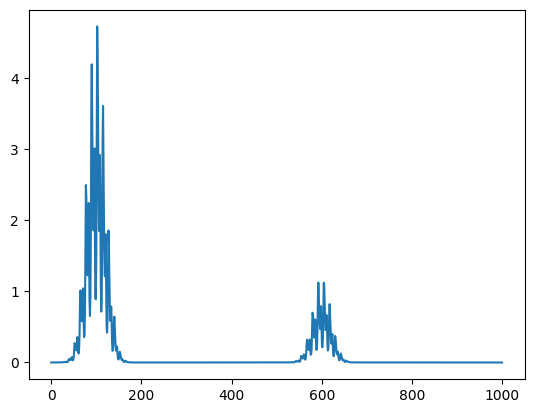

In [3]:
t = np.linspace(0, 1000, 1000)

s = (
        np.exp(
            np.sin(t/2)
        ) + np.exp(
            np.sin(t)
        )
    ) * np.exp(
        -(t - 100)**2 / (2 * 20**2)
    ) + 0.25*(
        np.exp(
            np.sin(t/2)
        ) + np.exp(
            np.sin(t)
        )
    ) * np.exp(
        -(t - 600)**2 / (2 * 20**2)
    )

plt.plot(t, s)

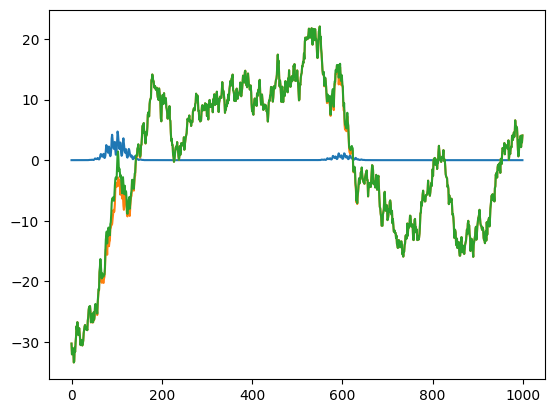

In [4]:
import scipy as sp

original_sig = s#gaussian_random_walk(100)
additional_sig = sp.signal.detrend(gaussian_random_walk(1000))

plt.plot(original_sig)
plt.plot(additional_sig)
plt.plot(original_sig + additional_sig)

In [18]:
n_epochs = 1000
n_channels = 60

poor_data = np.array([ [ sp.signal.detrend(gaussian_random_walk(1000)) for __ in range(n_channels)] for _ in range(n_epochs)])

# distances = np.random.random(n_channels)
distances = np.random.normal(0.5, .2, n_channels - 2)
ratio = 2*np.random.randint(0, 2, n_channels) - 1

In [19]:
np.expand_dims(distances, -1)

array([[0.40676789],
       [0.58852229],
       [0.74006951],
       [0.41441506],
       [0.39030261],
       [0.7984915 ],
       [0.6047245 ],
       [0.51269348],
       [0.38371995],
       [0.63724204],
       [0.65410517],
       [0.44186821],
       [0.31460303],
       [0.59461954],
       [0.3475872 ],
       [0.40446075],
       [0.50247528],
       [0.41705659],
       [0.20721141],
       [0.58066295],
       [0.54772054],
       [0.48603567],
       [0.38349121],
       [0.61835748],
       [0.72763022],
       [0.27506386],
       [0.74477163],
       [0.43892089],
       [0.77004571],
       [0.74310701],
       [0.61939   ],
       [0.47104192],
       [0.05161339],
       [0.3828064 ],
       [0.33840446],
       [0.40805956],
       [1.13029182],
       [0.49615201],
       [0.42057235],
       [0.57400884],
       [0.57938607],
       [0.74459314],
       [0.18309064],
       [0.65052964],
       [0.4236485 ],
       [0.37716265],
       [0.83735513],
       [0.555

In [20]:
rich_data = np.array([ [ channel + r*distance*original_sig for r, channel, distance in zip(ratio, epoch, distances) ] for epoch in poor_data])

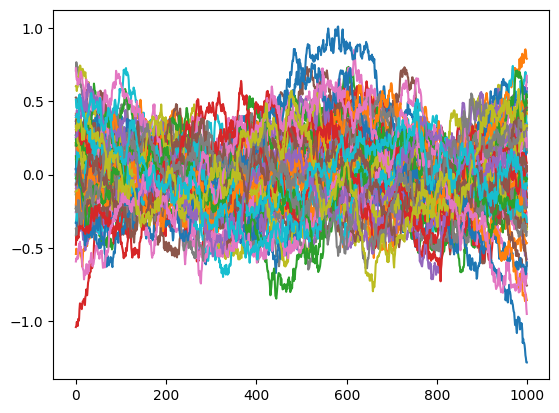

In [21]:
fig = plt.plot(poor_data.mean(0).T)

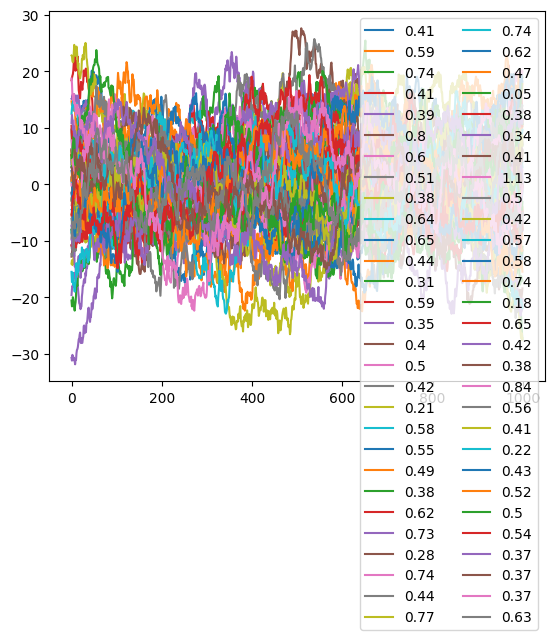

In [22]:
i = int(np.random.randint(len(rich_data)))

fig = plt.plot(rich_data[i].T)
plt.legend(np.round(distances, 2), ncol=2, loc='upper right')

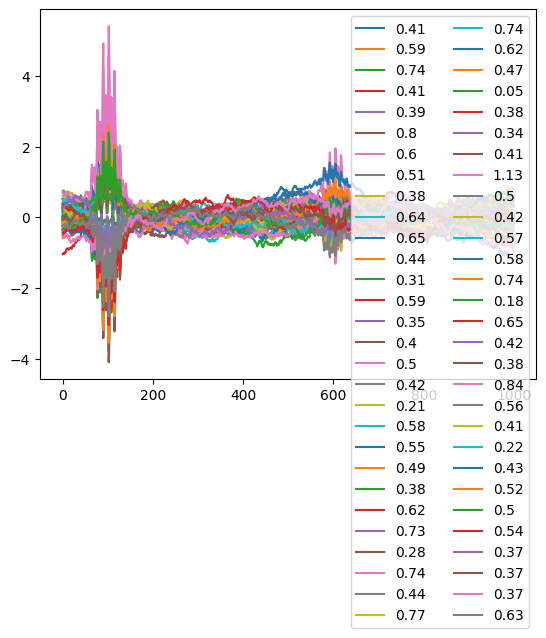

In [23]:
fig = plt.plot(rich_data.mean(0).T)
plt.legend(np.round(distances, 2), ncol=2, loc='upper right')

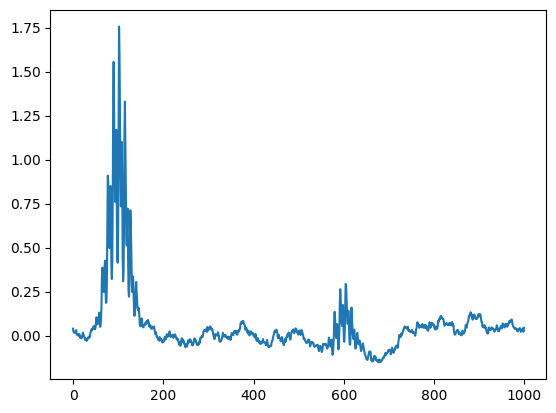

In [14]:
fig = plt.plot(rich_data.mean((0, 1)).T)

In [11]:
data_weighted = np.transpose(np.transpose(rich_data.copy(), (0, 2, 1))@np.expand_dims(distances, 1), (0, 2, 1))

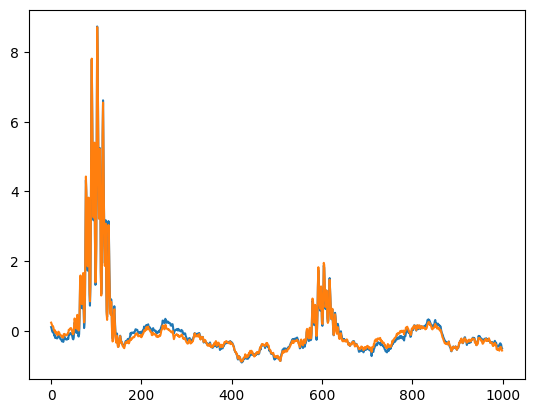

In [12]:
plt.plot(sp.stats.zscore(rich_data.mean((0, 1)).T))
fig = plt.plot(sp.stats.zscore(data_weighted.mean((0, 1)).T))

In [13]:
dist_vec = np.expand_dims(distances, 1)
data_vec = np.transpose(rich_data.copy(), (0, 2, 1))

In [14]:
data_vec[:, 50:150, :] = data_vec[:, 50:150, :]@dist_vec

In [15]:
data_vec[:, 550:650, :] = data_vec[:, 550:650, :]@dist_vec

In [16]:
data_weighted2 = np.transpose(data_vec, (0, 2, 1))

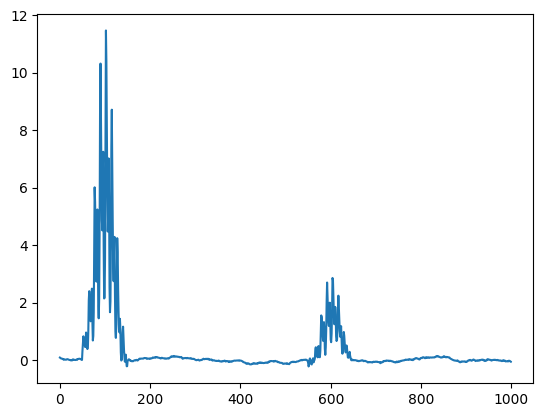

In [17]:
fig = plt.plot(data_weighted2.mean((0, 1)).T)

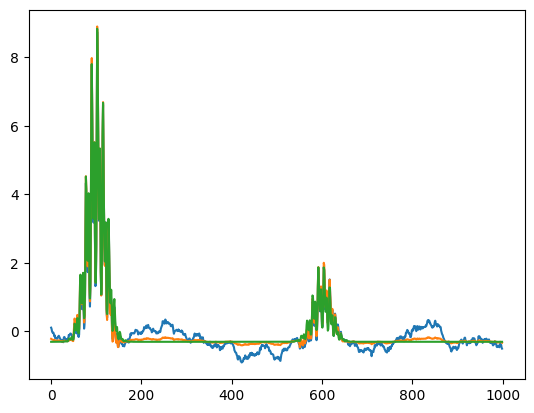

In [18]:
plt.plot(sp.stats.zscore(rich_data.mean((0, 1)).T))
plt.plot(sp.stats.zscore(data_weighted2.mean((0, 1)).T))
plt.plot(sp.stats.zscore(original_sig))
plt.show()

In [89]:
X = poor_data[:, :-2]

In [105]:
X = rich_data

In [29]:
Y = np.array([original_sig for _ in range(len(X))])

In [106]:
from deepmeg.preprocessing.transforms import zscore

dataset = EpochsDataset((X, Y), transform=zscore, target_transform=zscore, savepath='../datasets/simulated_sources')
dataset.save('../data/simulated_sources.pt')

In [21]:
dataset = EpochsDataset.load('../data/simulated_sources.pt')

In [91]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [25]:
class Unmixer(BaseModel):
    def __init__(self, n_channels, filter_size):
        super().__init__()
        self.temp_conv = nn.Conv1d(n_channels, n_channels, kernel_size=filter_size, bias=True, groups=n_channels, padding='same')
        self.unmixing_layer = nn.Conv1d(n_channels, 1, kernel_size=1, bias=False)
        # self.temp_conv = nn.Conv1d(1, 1, kernel_size=filter_size, bias=True, groups=1, padding='same')

    def forward(self, x):
        # x = self.temp_conv(x)
        x = self.unmixing_layer(x)
        # x = self.temp_conv(x)
        return torch.squeeze(x, 1)

In [26]:
X, y = next(iter(DataLoader(train, 10)))

In [27]:

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [28]:
Unmixer(10, 50)(X).shape

torch.Size([10, 1000])

In [31]:
model = Unmixer(
    n_channels=10,
    filter_size=50
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

# loss = torch.nn.BCEWithLogitsLoss()
loss = torch.nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', patience=15, restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)

Epoch 0:  loss_train:  0.7520   |    loss_val:  0.7525
Epoch 1:  loss_train:  0.7466   |    loss_val:  0.7470
Epoch 2:  loss_train:  0.7412   |    loss_val:  0.7414
Epoch 3:  loss_train:  0.7359   |    loss_val:  0.7360
Epoch 4:  loss_train:  0.7306   |    loss_val:  0.7305
Epoch 5:  loss_train:  0.7253   |    loss_val:  0.7252
Epoch 6:  loss_train:  0.7201   |    loss_val:  0.7199
Epoch 7:  loss_train:  0.7150   |    loss_val:  0.7146
Epoch 8:  loss_train:  0.7099   |    loss_val:  0.7094
Epoch 9:  loss_train:  0.7048   |    loss_val:  0.7042
Epoch 10: loss_train:  0.6998   |    loss_val:  0.6991
Epoch 11: loss_train:  0.6949   |    loss_val:  0.6941
Epoch 12: loss_train:  0.6899   |    loss_val:  0.6891
Epoch 13: loss_train:  0.6851   |    loss_val:  0.6842
Epoch 14: loss_train:  0.6803   |    loss_val:  0.6793
Epoch 15: loss_train:  0.6755   |    loss_val:  0.6744
Epoch 16: loss_train:  0.6708   |    loss_val:  0.6697
Epoch 17: loss_train:  0.6661   |    loss_val:  0.6650
Epoch 18: 

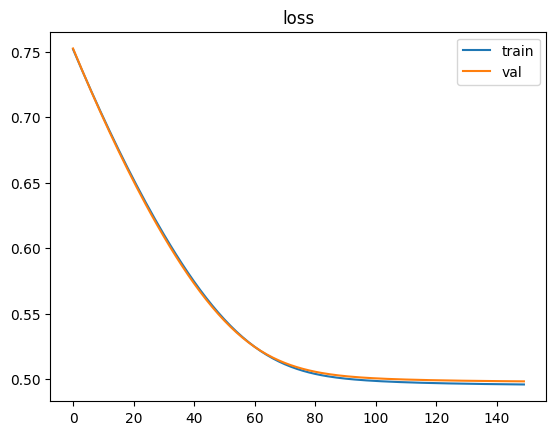

In [32]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [38]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.496564456820488
loss: 0.4983897417783737


In [39]:
x_test, y_test = next(iter(DataLoader(test, len(test))))

In [40]:
w = model.unmixing_layer.weight.detach().numpy()

In [41]:
np.corrcoef(np.squeeze(np.cov(np.reshape(np.transpose(x_test, (1, 0, -1)), (10, 300000)))@w), distances)[0, 1]

0.2521036237263819

In [42]:
y_pred = model(x_test).detach().numpy()

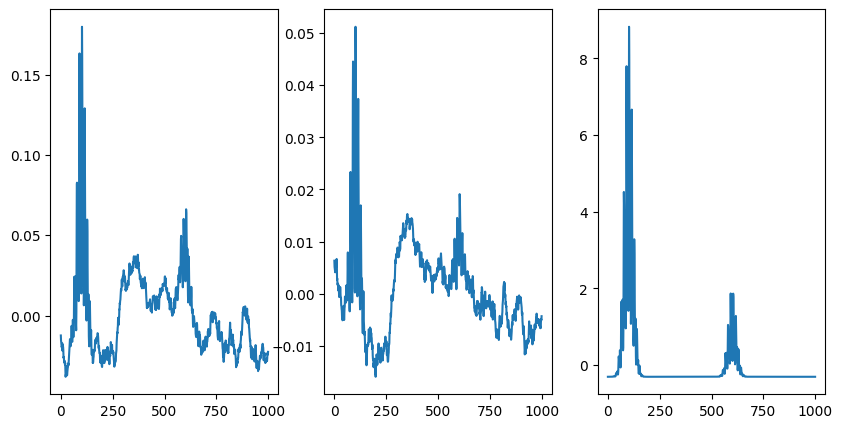

In [43]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

7


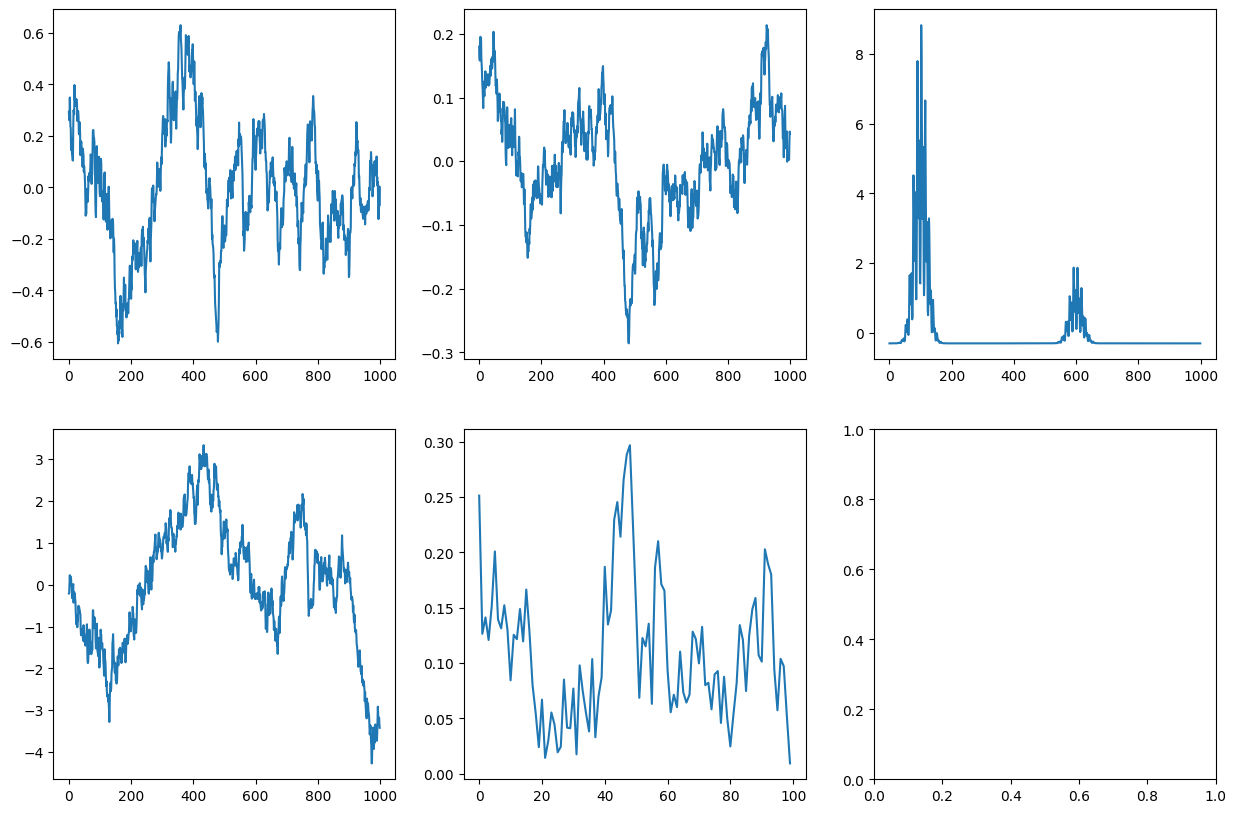

In [44]:
i = int(np.random.randint(len(y_pred)))
print(i)
# data_weighted2
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

x_weighted = (x_test[0].T@distances)

x_weighted2 = x_test[0].T.numpy().copy()
x_weighted2_ = x_weighted2.mean(1)
x_weighted2_[50:150] = x_weighted2[50:150]@distances
x_weighted2_[550:650] = x_weighted2[550:650]@distances

axes[0, 0].plot(x_test[i].mean(0))
axes[0, 1].plot(y_pred[i])
axes[0, 2].plot(y_test[i])
axes[1, 0].plot(x_weighted)
axes[1, 1].plot(np.abs(sp.signal.hilbert(y_pred[i]))[: :10])

In [48]:
from deepmeg.layers import FourieCov1D

class FourierSPIRIT(BaseModel):
    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        window_size: int,
        latent_dim: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.timesel_list = nn.ModuleList([
            nn.Sequential(
                FourieCov1D(1, window_size, latent_dim, 0, window_size, bias=True),
            )
            for _ in range(n_latent)
        ])
        self.expander = nn.Conv1d(
            in_channels=n_latent,
            out_channels=n_latent,
            kernel_size=(2,),
            padding=1
        )
        self.windows = [win for win, _, _ in conviter((n_times-(window_size),), window_size, 0, window_size)]
        self.windows.append(slice(self.windows[-1].start + window_size, None))
        self.timecomp_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(
                    n_times,
                    (n_times//pool_factor),
                    bias=False
                ),
                nn.Dropout(.25),
                torch.nn.Sigmoid()
            )
            for i in range(n_latent)
        ])
        final_out_features = (n_times//pool_factor)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        # x = self.temp_conv(x)
        x_est = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timesel_list)
            ],
            1
        )

        x_est = torch.squeeze(x_est, -1)
        x_est = self.expander(x_est)

        x_out = list()
        for i, window in enumerate(self.windows):
            x_out.append(
                x[:, :, window]
                *torch.unsqueeze(x_est[:, :, i], -1)
            )

        x = torch.cat(x_out, -1)

        x = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timecomp_list)
            ],
            1
        )
        return torch.squeeze(x, 1)


model = FourierSPIRIT(
    10,
    1,
    1000,
    50,
    20,
    20,
    1,
    1000
)

optimizer = torch.optim.Adam
loss = torch.nn.L1Loss()

model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', patience=15, restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)


In [47]:
sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.8690   |    loss_val:  0.8499
Epoch 1:  loss_train:  0.8399   |    loss_val:  0.8196
Epoch 2:  loss_train:  0.8093   |    loss_val:  0.7861
Epoch 3:  loss_train:  0.7775   |    loss_val:  0.7502
Epoch 4:  loss_train:  0.7452   |    loss_val:  0.7129
Epoch 5:  loss_train:  0.7172   |    loss_val:  0.6794
Epoch 6:  loss_train:  0.6878   |    loss_val:  0.6488
Epoch 7:  loss_train:  0.6609   |    loss_val:  0.6196
Epoch 8:  loss_train:  0.6364   |    loss_val:  0.5907
Epoch 9:  loss_train:  0.6194   |    loss_val:  0.5665
Epoch 10: loss_train:  0.5973   |    loss_val:  0.5454
Epoch 11: loss_train:  0.5849   |    loss_val:  0.5262
Epoch 12: loss_train:  0.5743   |    loss_val:  0.5099
Epoch 13: loss_train:  0.5637   |    loss_val:  0.4958
Epoch 14: loss_train:  0.5555   |    loss_val:  0.4836
Epoch 15: loss_train:  0.5500   |    loss_val:  0.4730
Epoch 16: loss_train:  0.5435   |    loss_val:  0.4641
Epoch 17: loss_train:  0.5389   |    loss_val:  0.4561
Epoch 18: 

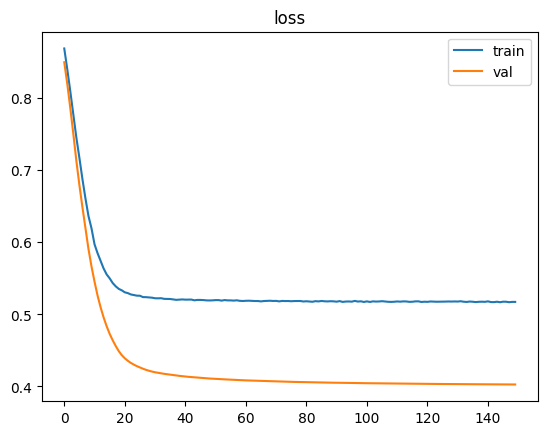

In [49]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [50]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.4027016878128052
loss: 0.40271924138069154


In [51]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()
w = model.unmixing_layer.weight.detach().numpy()
np.corrcoef(np.squeeze(np.cov(np.reshape(np.transpose(x_test, (1, 0, -1)), (10, 300000)))@w), distances)[0, 1]

0.365805103300986

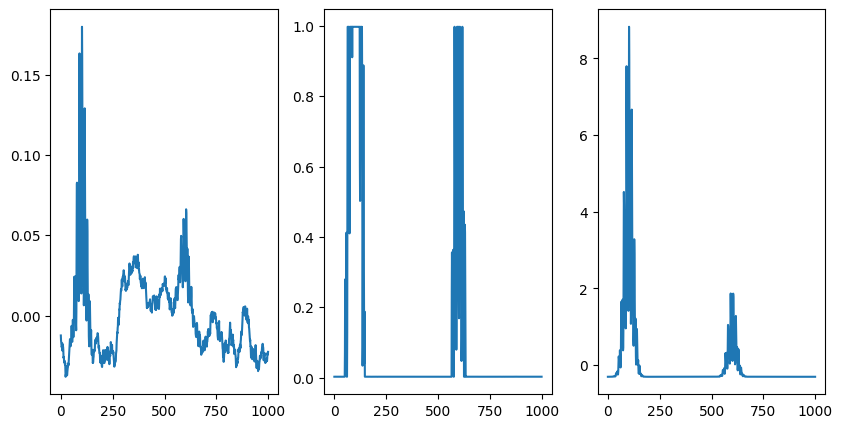

In [52]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

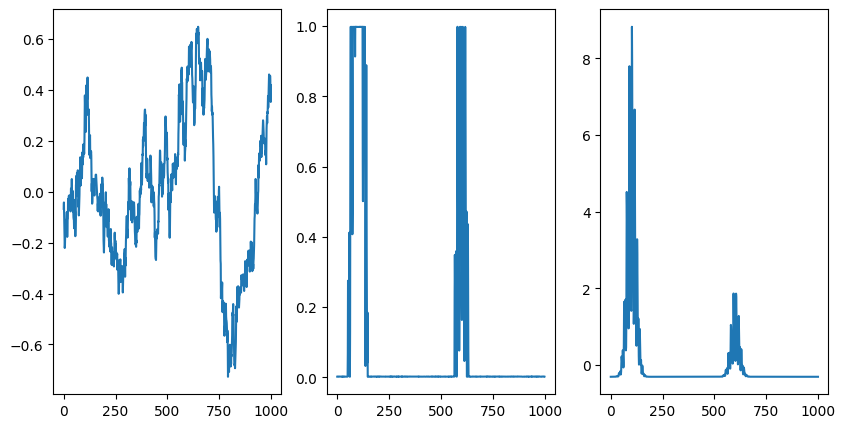

In [58]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])

In [61]:

class LFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        return torch.squeeze(x, 1)

model = LFCNN(
    10,
    1,
    1000,
    50,
)

optimizer = torch.optim.Adam
loss = torch.nn.L1Loss()

model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', patience=15, restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)

  0%|          | 0/150 [00:00<?, ?it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0:  loss_train:  0.5120   |    loss_val:  0.5072
Epoch 1:  loss_train:  0.5086   |    loss_val:  0.5041
Epoch 2:  loss_train:  0.5055   |    loss_val:  0.5007
Epoch 3:  loss_train:  0.5023   |    loss_val:  0.4975
Epoch 4:  loss_train:  0.4992   |    loss_val:  0.4945
Epoch 5:  loss_train:  0.4961   |    loss_val:  0.4916
Epoch 6:  loss_train:  0.4932   |    loss_val:  0.4887
Epoch 7:  loss_train:  0.4902   |    loss_val:  0.4858
Epoch 8:  loss_train:  0.4873   |    loss_val:  0.4829
Epoch 9:  loss_train:  0.4844   |    loss_val:  0.4800
Epoch 10: loss_train:  0.4815   |    loss_val:  0.4771
Epoch 11: loss_train:  0.4785   |    loss_val:  0.4742
Epoch 12: loss_train:  0.4755   |    loss_val:  0.4712
Epoch 13: loss_train:  0.4726   |    loss_val:  0.4683
Epoch 14: loss_train:  0.4695   |    loss_val:  0.4652
Epoch 15: loss_train:  0.4665   |    loss_val:  0.4622
Epoch 16: loss_train:  0.4634   |    loss_val:  0.4592
Epoch 17: loss_train:  0.4603   |    loss_val:  0.4561
Epoch 18: 

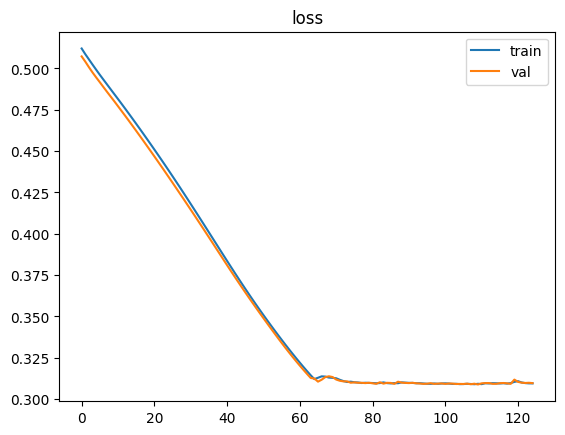

In [62]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [63]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.3088015139102936
loss: 0.3087972640991211


In [64]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()
w = model.unmixing_layer.weight.detach().numpy()
np.corrcoef(np.squeeze(np.cov(np.reshape(np.transpose(x_test, (1, 0, -1)), (10, 300000)))@w), distances)[0, 1]

0.37628602723494053

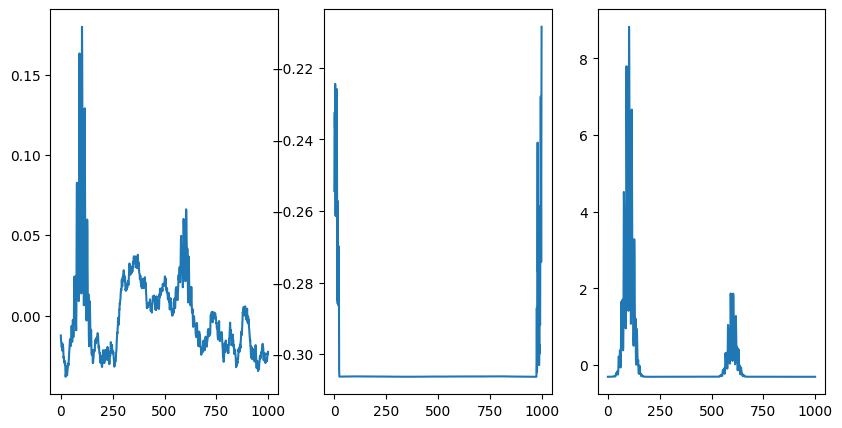

In [65]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

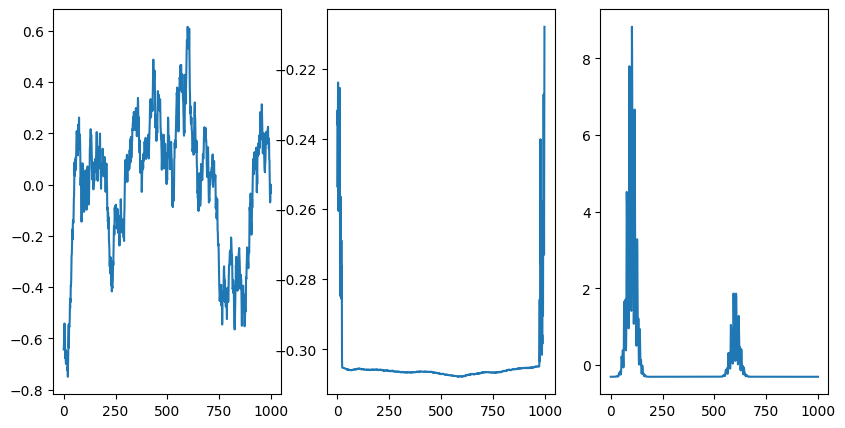

In [67]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])

In [68]:
class RUnmixer(BaseModel):
    def __init__(self, n_channels, n_hidden=1):
        super().__init__()
        self.unmixing_layer = nn.LSTM(n_channels, n_hidden, 1, batch_first=True)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        x, _ = self.unmixing_layer(x)
        return torch.squeeze(x, -1)

In [69]:
RUnmixer(10)(X).shape

torch.Size([10, 1000])

In [59]:
sys.stdout = sys.stdout.file

In [70]:
model = RUnmixer(
    n_channels=10,
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

# loss = torch.nn.BCEWithLogitsLoss()
loss = torch.nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=True),
        # L2Reg(
        #     [
        #         'unmixing_layer.weight'
        #     ], lambdas=.01
        # )
    ]
)

Epoch 0:  loss_train:  0.5565   |    loss_val:  0.5546
Epoch 1:  loss_train:  0.5546   |    loss_val:  0.5528
Epoch 2:  loss_train:  0.5528   |    loss_val:  0.5509
Epoch 3:  loss_train:  0.5509   |    loss_val:  0.5490
Epoch 4:  loss_train:  0.5490   |    loss_val:  0.5471
Epoch 5:  loss_train:  0.5472   |    loss_val:  0.5453
Epoch 6:  loss_train:  0.5454   |    loss_val:  0.5435
Epoch 7:  loss_train:  0.5435   |    loss_val:  0.5416
Epoch 8:  loss_train:  0.5417   |    loss_val:  0.5398
Epoch 9:  loss_train:  0.5399   |    loss_val:  0.5381
Epoch 10: loss_train:  0.5381   |    loss_val:  0.5363
Epoch 11: loss_train:  0.5363   |    loss_val:  0.5345
Epoch 12: loss_train:  0.5346   |    loss_val:  0.5328
Epoch 13: loss_train:  0.5328   |    loss_val:  0.5311
Epoch 14: loss_train:  0.5311   |    loss_val:  0.5294
Epoch 15: loss_train:  0.5294   |    loss_val:  0.5277
Epoch 16: loss_train:  0.5277   |    loss_val:  0.5260
Epoch 17: loss_train:  0.5260   |    loss_val:  0.5244
Epoch 18: 

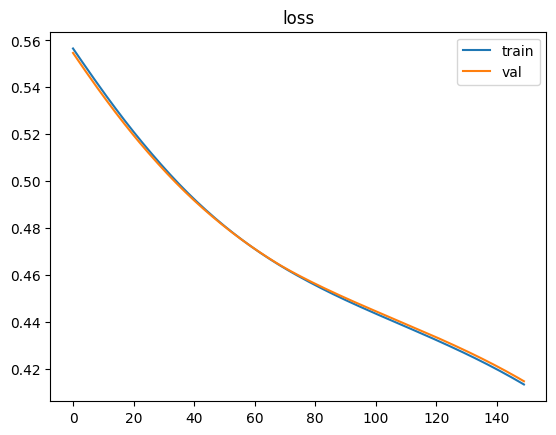

In [71]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [72]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.4131696254014969
loss: 0.41289533376693727


In [73]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()


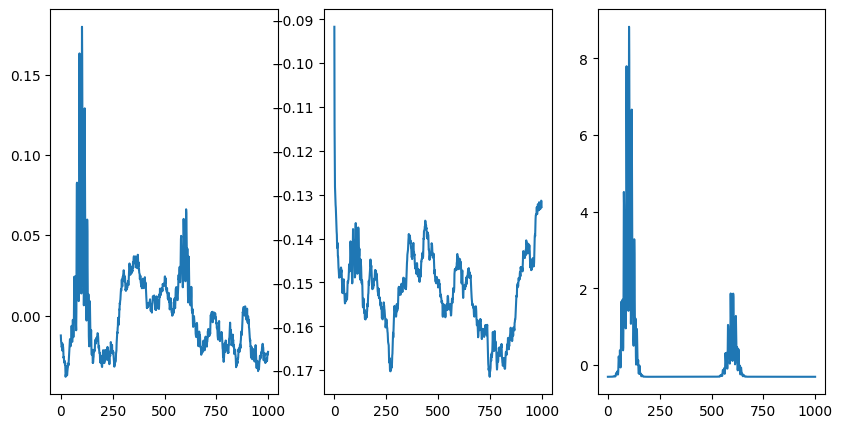

In [74]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

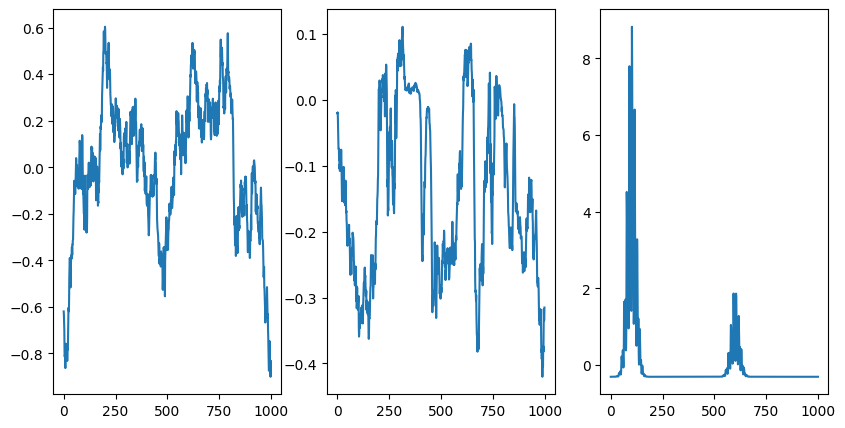

In [77]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])

In [221]:
original_sig[100]

1.466104107263605

In [235]:
np.expand_dims(np.ones(10)*original_sig[100]/10, -1)

array([[0.14661041],
       [0.14661041],
       [0.14661041],
       [0.14661041],
       [0.14661041],
       [0.14661041],
       [0.14661041],
       [0.14661041],
       [0.14661041],
       [0.14661041]])

In [225]:
ch_data = np.expand_dims(rich_data[0, :, 100], -1)

In [229]:
ch_data

array([[ -4.63333099],
       [  3.79352224],
       [  4.47909165],
       [  5.16951469],
       [-12.91376999],
       [ -6.00552429],
       [ -6.34892884],
       [ -0.07493449],
       [ -7.76434553],
       [  5.70601569]])

In [241]:
a = ch_data/np.expand_dims(np.ones(10)*original_sig[100]/10, -1)

In [245]:
a*np.expand_dims(np.ones(10)*original_sig[100]/10, -1)

array([[ -4.63333099],
       [  3.79352224],
       [  4.47909165],
       [  5.16951469],
       [-12.91376999],
       [ -6.00552429],
       [ -6.34892884],
       [ -0.07493449],
       [ -7.76434553],
       [  5.70601569]])

In [253]:
(a*ch_data).sum()

2855.4225829380475

In [256]:
a.T@ch_data

array([[2855.42258294]])

In [267]:
X.shape

torch.Size([70, 10, 100])

In [24]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch


class TS(nn.Module):
    def __init__(self, n_channels, n_times):
        super().__init__()
        self.n_channels = n_channels
        self.n_times = n_times
        self.i = nn.Parameter(torch.empty(self.n_times, self.n_channels))
        # self.s = nn.Parameter(torch.empty(1, self.n_channels))
        self.b = nn.Parameter(torch.empty(1, self.n_times))
        self.reset_parameters()
        self.x_prev = 0

    def reset_parameters(self) -> None:
        init.uniform_(self.i, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        # init.uniform_(self.s, -0.01, 0.01)

    def forward(self, x):
        out = torch.zeros(x.shape[0], self.n_times)
        for i in range(self.n_times):
            timepoint = x[:, :, i]
            # print(timepoint.shape)
            # sp_filter = self.i[i]@self.s
            out[:, i] = self.i[i]@timepoint.T

        return out + self.b


X = torch.rand(70, 10, 100)
TS(10, 100)(X).shape

torch.Size([70, 100])

In [269]:
X.shape

torch.Size([10, 10, 1000])

In [25]:
class TSUnmixer(BaseModel):
    def __init__(self, n_channels, n_times):
        super().__init__()
        self.unmixing_layer = TS(n_channels, n_times)

    def forward(self, x):
        return self.unmixing_layer(x)

In [35]:
X, y = next(iter(Datnp.array([
    0.49184228,
    0.02686718,
    0.62581,
    0.39959123,
    0.30505363,
    0.,
    0.71030595,
    0.49824701,
    0.,
    0.43895349,
])aLoader(train)))
X.shape

torch.Size([1, 58, 1000])

In [36]:
model = TSUnmixer(
    n_channels=58,
    n_times=1000
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

# loss = torch.nn.BCEWithLogitsLoss()
loss = torch.nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', patience=15, restore_best_weights=True),
        # L2Reg(
        #     [
        #         'unmixing_layer.weight'
        #     ], lambdas=.01
        # )
    ]
)

In [34]:
sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.4961   |    loss_val:  0.4929
Epoch 1:  loss_train:  0.4874   |    loss_val:  0.4882
Epoch 2:  loss_train:  0.4794   |    loss_val:  0.4835
Epoch 3:  loss_train:  0.4715   |    loss_val:  0.4789
Epoch 4:  loss_train:  0.4638   |    loss_val:  0.4744
Epoch 5:  loss_train:  0.4562   |    loss_val:  0.4699
Epoch 6:  loss_train:  0.4488   |    loss_val:  0.4656
Epoch 7:  loss_train:  0.4417   |    loss_val:  0.4615
Epoch 8:  loss_train:  0.4351   |    loss_val:  0.4576
Epoch 9:  loss_train:  0.4289   |    loss_val:  0.4539
Epoch 10: loss_train:  0.4232   |    loss_val:  0.4504
Epoch 11: loss_train:  0.4179   |    loss_val:  0.4470
Epoch 12: loss_train:  0.4129   |    loss_val:  0.4436
Epoch 13: loss_train:  0.4081   |    loss_val:  0.4401
Epoch 14: loss_train:  0.4035   |    loss_val:  0.4367
Epoch 15: loss_train:  0.3989   |    loss_val:  0.4331
Epoch 16: loss_train:  0.3945   |    loss_val:  0.4294
Epoch 17: loss_train:  0.3902   |    loss_val:  0.4258
Epoch 18: 

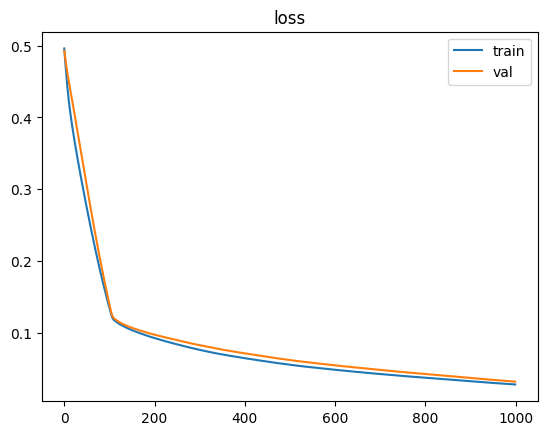

In [37]:
history = model.fit(train, n_epochs=1000, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [38]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.028472032770514487
loss: 0.035019130632281306


In [92]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()


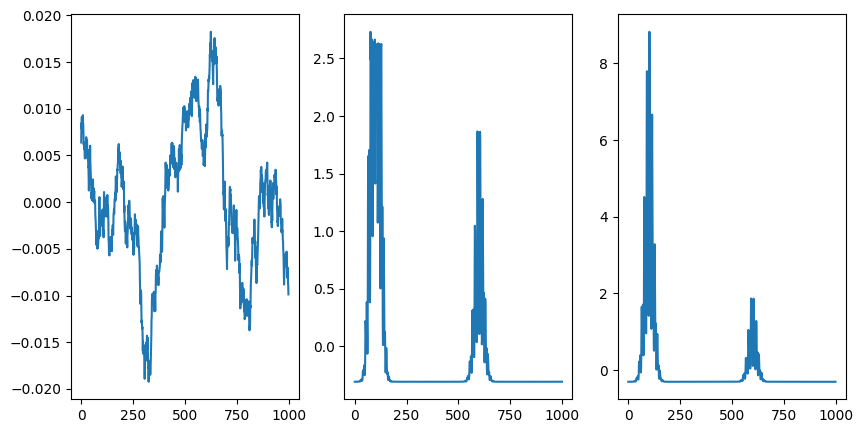

In [99]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

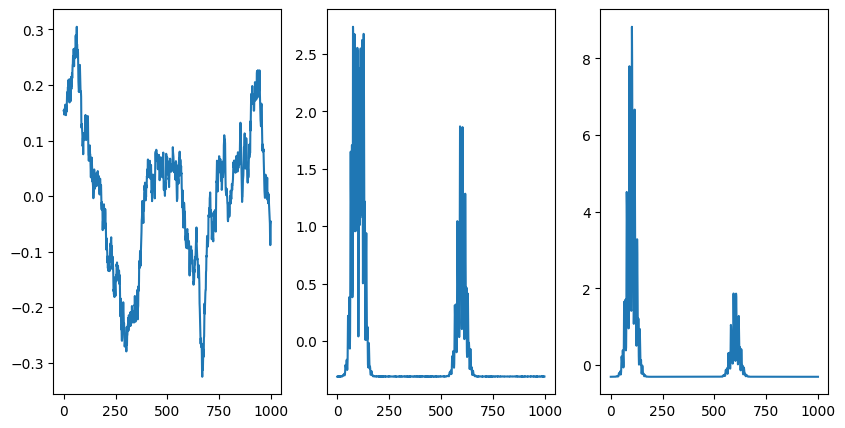

In [104]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])

In [151]:
w = model.unmixing_layer.i.detach().numpy()

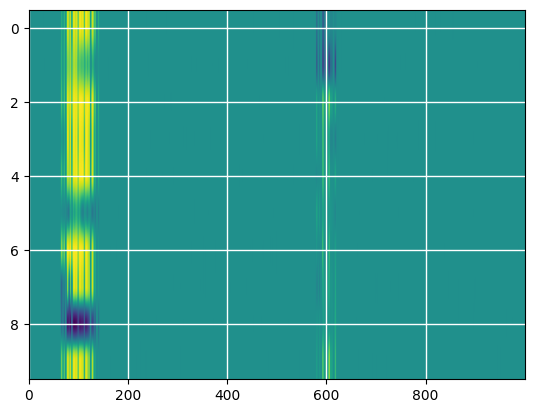

In [152]:
fig, ax = plt.subplots(1, 1)

ax.imshow(w.T, aspect='auto')
ax.grid(color='w', linewidth=1, which='both')

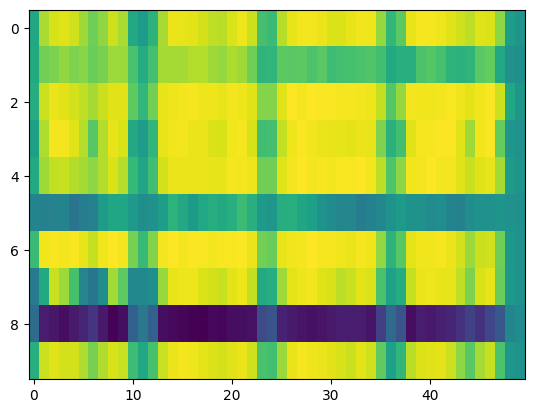

In [153]:
fig, ax = plt.subplots(1, 1)

ax.imshow(w.T[:, 75:125], aspect='auto')
# plt.pcolormesh(w.T, edgecolors='k', linewidth=2)

# ax.grid(color='w', linewidth=1, which='both')

In [126]:
for i, d in enumerate(distances):
    print(f'{i}: {d : .2f}')

0:  0.49
1:  0.03
2:  0.63
3:  0.40
4:  0.31
5:  0.00
6:  0.71
7:  0.50
8:  0.00
9:  0.44


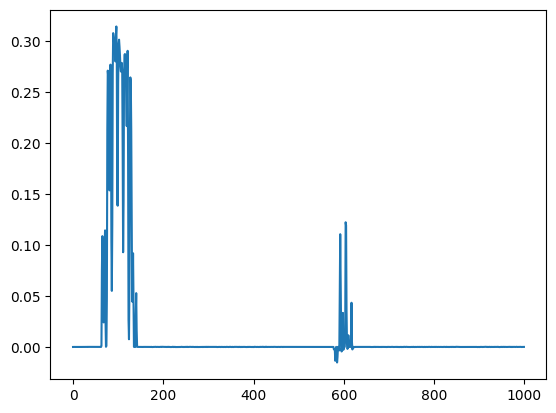

In [154]:
plt.plot(w.mean(1))

In [79]:
from collections import namedtuple

KeyResp = namedtuple('KeyResp', 'keys')
Text = namedtuple('Text', 'text')

text_12 = Text('Press J')
key_resp2 = KeyResp('f')

if (
    (
        key_resp2.keys == 'f' and text_12.text =='Press F'
    ) or (
        key_resp2.keys == 'j' and text_12.text =='Press J'
    )
):
    doleft, doright = 1, 0

elif (
    (
        key_resp2.keys == 'j' and text_12.text =='Press F'
    ) or (
        key_resp2.keys == 'f' and text_12.text =='Press J'
    )
):

    doleft, doright = 0, 1

doleft, doright

(0, 1)